In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

## NAICS Embeddings - Distances and Analytics
Look at the position of holdout NAICS in the embedding space.  Also look at distances for some scenarios (holdout codes, train nullified vs. actual)

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib

In [3]:
import matplotlib.pyplot as plt
from sba_nn.sba_nn import sbnn_plot, sbnn_embed

In [4]:
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
sbnn_plot.plot_defaults()

## Import Data

##### NAICS info

In [7]:
naics_info = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_naics_info.parquet'))

In [8]:
# Truncate target rates below a threshold
naics_info['target_thresh'] = naics_info['target'].where(naics_info['count'] >= setup.plot_thresh, np.nan)

In [9]:
naics_info.sort_values('NAICS_orig').head(3)

,NAICS_orig,NAICS_4_orig,NAICS_3_orig,NAICS_sector_orig,dset_naics_holdout,target,count,target_thresh
1188,111110,1111,111,11,0.0,0.03125,32,NaN
1234,111120,1111,111,11,0.0,0.00000,3,NaN
1267,111130,1111,111,11,0.0,0.00000,1,NaN


In [10]:
naics_features = ['NAICS_orig', 'NAICS_4_orig', 'NAICS_3_orig', 'NAICS_sector_orig']

##### Embeddings

In [11]:
emb_all = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embeddings.parquet'))

In [12]:
emb_all.head(2)

,NAICS_orig,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,dset_naics_holdout,NAICS_4_orig,NAICS_3_orig,NAICS_sector_orig,model
index,,,,,,,,,,,,,,
0,111110,-1.254599,-0.502711,1.386203,0.718435,1.162957,-0.964266,1.528816,1.302754,0.0,1111,111,11,03
1,111120,-0.099621,-0.136136,0.118702,0.129463,0.138247,0.011411,0.192569,0.126672,0.0,1111,111,11,03


In [13]:
emb_features = [c for c in emb_all if c.startswith('emb_')]
print(emb_features)

['emb_00', 'emb_01', 'emb_02', 'emb_03', 'emb_04', 'emb_05', 'emb_06', 'emb_07']


In [14]:
# Missing value embeddings for "A" models
emb_all_miss = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embeddings_missing.parquet'))

##### Model info

In [15]:
model_info_frame = pd.read_csv(Path(setup.temp_path).joinpath('A10_REPORT_model_info.csv'))

In [16]:
model_info_frame

,model,model_path,model_hier,model_rand,model_layer_name
0,03,../data/2024_05_16/03_DATA_model.keras,False,False,NAICS
1,11,../data/2024_05_16/11_DATA_model.keras,False,True,NAICS
2,04,../data/2024_05_16/04_DATA_model.keras,True,False,NAICS
3,12,../data/2024_05_16/12_DATA_model.keras,True,True,NAICS
4,A01,../data/2024_06_04/A01_DATA_model.keras,True,True,embedding_int
5,A02,../data/2024_06_04/A02_DATA_model.keras,True,False,embedding_int


## Get TSNE values

In [17]:
groups = emb_all.groupby('model')
tsne_raw = pd.concat([sbnn_embed.tsne_transform(g[emb_features]) for n, g in groups],
                     keys=groups.groups.keys())

In [18]:
# Append sector, mean info

In [19]:
tsne_df = pd.concat([emb_all.set_index('model', append=True)[['NAICS_orig']] \
            .reorder_levels(['model', 'index']),
          tsne_raw], axis=1) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'}, errors='ignore') \
    .merge(naics_info[['NAICS_orig','NAICS_sector_orig', 'target_thresh', 'count',
                      'dset_naics_holdout']], 
           how='left', on ='NAICS_orig') \
    .sort_values(['model', 'NAICS_orig']) \
    .reset_index(drop=True) \
    .rename(columns={0:'tsne_0', 1:'tsne_1'})
tsne_df

,model,NAICS_orig,tsne_0,tsne_1,NAICS_sector_orig,target_thresh,count,dset_naics_holdout
0,03,111110,62.021053,3.818658,11,NaN,32,0.0
1,03,111120,-24.330986,-6.605319,11,NaN,3,0.0
2,03,111130,-23.113844,-3.716676,11,NaN,1,0.0
3,03,111140,54.652363,0.788965,11,NaN,94,0.0
4,03,111150,47.548595,-8.982228,11,NaN,49,0.0
...,...,...,...,...,...,...,...,...
7861,A02,926140,7.145362,-15.580339,92,NaN,6,0.0
7862,A02,926150,-29.227999,5.560966,92,NaN,10,0.0
7863,A02,927110,41.656750,-15.611317,92,NaN,1,0.0
7864,A02,928110,8.655744,18.231609,92,NaN,4,0.0


In [20]:
tsne_df.to_parquet(Path(setup.temp_path).joinpath('A10_DATA_embed_tsne.parquet'))

## TSNE plots

In [21]:
importlib.reload(sbnn_embed)

<module 'sba_nn.sba_nn.sbnn_embed' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_embed.py'>

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

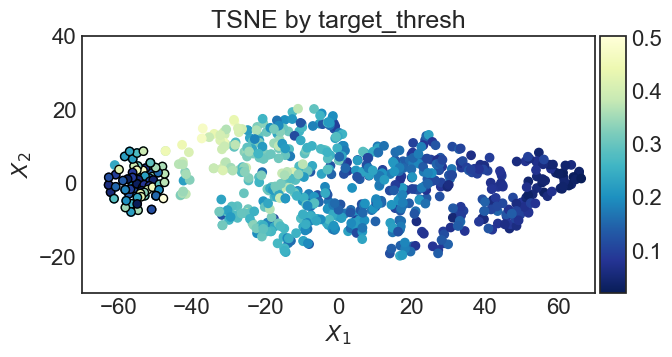

In [22]:
sbnn_embed.emb_color_plot(tsne_df[tsne_df['model'] == '03'], 'target_thresh',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-70,70], ylim=[-30, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A11_PLOT_naics_only_nohier_norand_03')

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

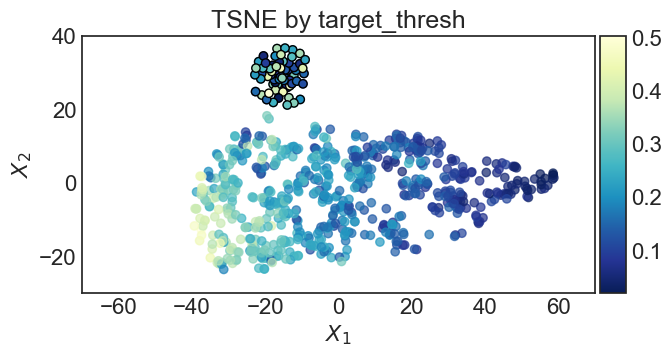

In [23]:
sbnn_embed.emb_color_plot(tsne_df[tsne_df['model'] == '11'], 'target_thresh',
                          cmap=plt.get_cmap('YlGnBu_r'),
                         xlim=[-70,70], ylim=[-30, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A11_PLOT_naics_only_nohier_rand_11')

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

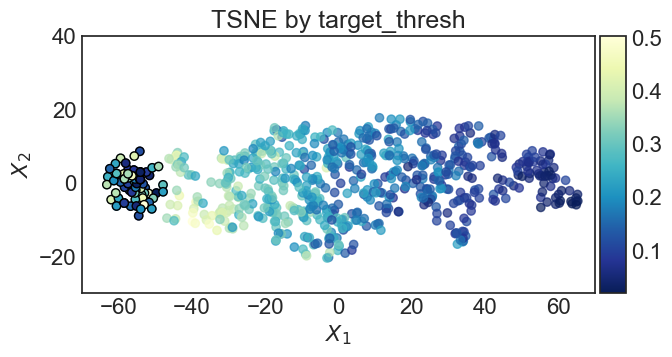

In [24]:
sbnn_embed.emb_color_plot(tsne_df[tsne_df['model'] == '04'], 'target_thresh',
                          cmap=plt.get_cmap('YlGnBu_r'),
                          xlim=[-70,70], ylim=[-30, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A11_PLOT_naics_hier_simple_norand_04')

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

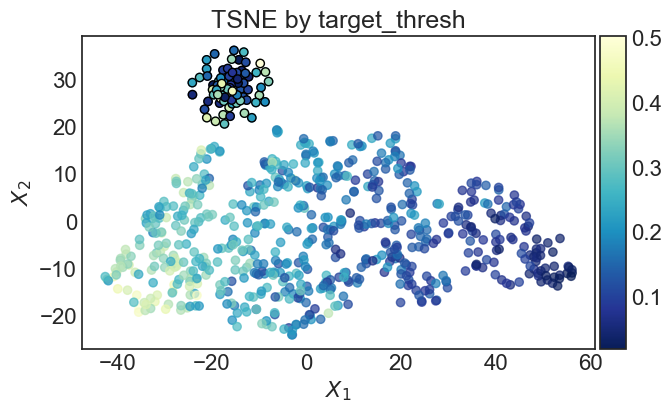

In [25]:
sbnn_embed.emb_color_plot(tsne_df[tsne_df['model'] == '12'], 'target_thresh',
                          cmap=plt.get_cmap('YlGnBu_r'),
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A11_PLOT_naics_hier_simple_rand_12')

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

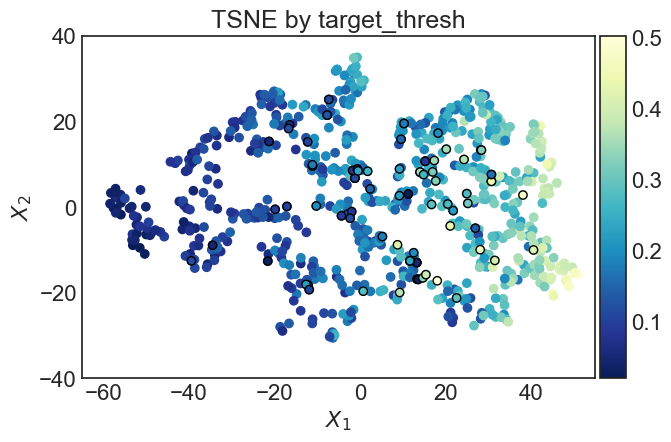

In [26]:
sbnn_embed.emb_color_plot(tsne_df[tsne_df['model'] == 'A01'], 'target_thresh',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha =1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A11_PLOT_naics_hier_layer_rand_A01')

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

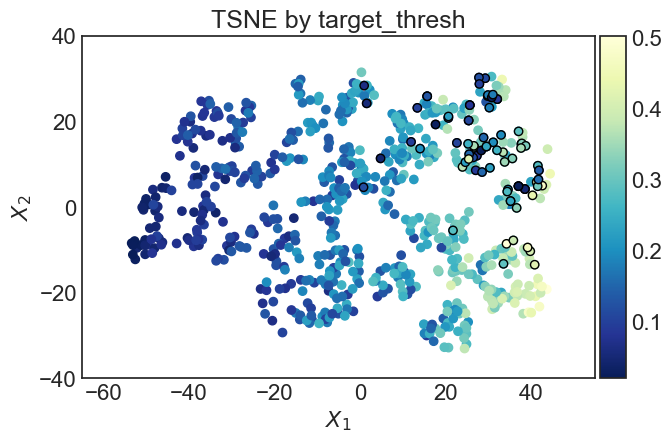

In [27]:
sbnn_embed.emb_color_plot(tsne_df[tsne_df['model'] == 'A02'], 'target_thresh',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A11_PLOT_naics_hier_layer_norand_A02')

## Distances from center

In [28]:
# Center points from each model
center_points = emb_all.groupby('model')[emb_features].mean().reset_index()

In [29]:
# Merge and subtract
emb_merge = emb_all[['model']].reset_index() \
    .merge(center_points, on='model') \
    .set_index('index')

In [30]:
emb_merge_sub = emb_merge[emb_features] - emb_all[emb_features]

In [31]:
emb_merge_sub

,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07
index,,,,,,,,
0,0.852512,0.270906,-1.020734,-0.413518,-0.739175,0.640677,-1.038093,-0.996985
1,-0.302466,-0.095669,0.246767,0.175454,0.285535,-0.335000,0.298154,0.179097
2,-0.273371,-0.140665,0.231439,0.274770,0.285081,-0.157349,0.324283,0.206638
3,0.432913,0.349200,-0.639808,-0.742245,-0.858792,0.277059,-0.696877,-0.532586
4,0.203783,0.695669,-0.590752,-0.518629,-0.326211,0.340065,-0.363392,-0.324542
...,...,...,...,...,...,...,...,...
1306,-0.010982,-0.035304,-0.008951,0.140098,0.169958,-0.121804,-0.211156,-0.064406
1307,0.303247,0.249803,0.263775,-0.269156,-0.031911,0.268797,0.270873,0.341589
1308,-0.442071,-0.462067,-0.430039,0.394249,0.148073,-0.457348,-0.385152,-0.589166


In [32]:
emb_merge_sub = emb_merge_sub.pow(2)

In [33]:
emb_all['dist'] = np.sqrt(emb_merge_sub.sum(axis=1))

##### Plot pairs

In [34]:
groups = emb_all.groupby('model')

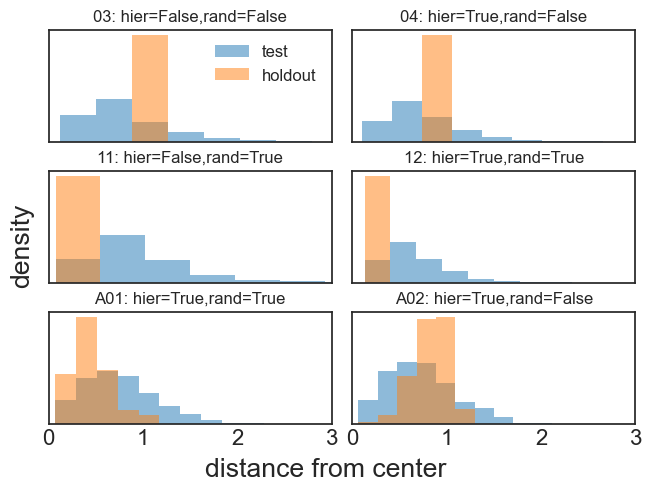

In [35]:
ncol = 2
nrow = int(np.ceil(len(groups) / ncol))
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=False,
                      layout='constrained')
i = 0
for n, g in groups:
    r = int(np.floor(i / ncol))
    c = i % ncol
    g[['dset_naics_holdout', 'dist']] \
        .reset_index() \
        .pivot(index='index', columns='dset_naics_holdout',
           values='dist') \
        .plot(kind='hist', bins=10, density=True, alpha=0.5,
             ax=ax[r, c])
    i+=1
    ax[r,c].get_legend().remove()
    ax[r,c].set_ylabel(None)
    ax[r,c].get_yaxis().set_visible(False)
    this_model_info = model_info_frame[model_info_frame['model'] == n].iloc[0,:]
    this_title = f'{n}: hier={this_model_info["model_hier"]},' + \
        f'rand={this_model_info["model_rand"]}'
    ax[r,c].set_title(this_title, fontsize=12)
ax[0, 0].legend(title=None, labels=['test', 'holdout'], fontsize=12)
ax[0,0].set_xlim([0,3])
fig.supxlabel('distance from center')
fig.supylabel('density')
fig.savefig(Path(setup.temp_path).joinpath('A11_PLOT_center_distances.png'))

In [36]:
model_info_frame

,model,model_path,model_hier,model_rand,model_layer_name
0,03,../data/2024_05_16/03_DATA_model.keras,False,False,NAICS
1,11,../data/2024_05_16/11_DATA_model.keras,False,True,NAICS
2,04,../data/2024_05_16/04_DATA_model.keras,True,False,NAICS
3,12,../data/2024_05_16/12_DATA_model.keras,True,True,NAICS
4,A01,../data/2024_06_04/A01_DATA_model.keras,True,True,embedding_int
5,A02,../data/2024_06_04/A02_DATA_model.keras,True,False,embedding_int


In [37]:
emb_dist_stats = emb_all.groupby(['model', 'dset_naics_holdout'])['dist'] \
    .agg(['mean', 'std', 'count', 'median'])
emb_dist_stats.to_csv(Path(setup.temp_path).joinpath('A11_REPORT_center_distances.csv'),
                     index=True)
emb_dist_stats

mean       std  count    median
model dset_naics_holdout                                     
03    0.0                 0.840697  0.487394   1180  0.720369
      1.0                 1.031457  0.000000    131  1.031457
04    0.0                 0.774074  0.438556   1180  0.672502
      1.0                 0.986631  0.000000    131  0.986631
11    0.0                 0.956180  0.548809   1180  0.835576
      1.0                 0.526339  0.000000    131  0.526339
12    0.0                 0.678312  0.370210   1180  0.601288
      1.0                 0.304014  0.000000    131  0.304014
A01   0.0                 0.751226  0.377427   1180  0.708630
      1.0                 0.457559  0.204536    131  0.431421
A02   0.0                 0.732610  0.362902   1180  0.699816
      1.0                 0.829230  0.183432    131  0.862188

## Missing Distances
Set non-holdout naics to missing, get distances from actual

##### Distances from non-"A" models 

In [38]:
emb_init = emb_all[~emb_all['model'].str.startswith('A')].copy() \
    .reset_index(drop=True)

In [39]:
dist_init_ref = emb_init[emb_init['dset_naics_holdout'] == 1] \
    .groupby('model') \
    [['model'] + emb_features] \
    .head(1) \
    .merge(emb_init[['model']].reset_index(), on='model') \
    .set_index('index')

In [40]:
dist_init_sub = np.sqrt((emb_init[emb_features] - dist_init_ref[emb_features]) \
    .pow(2).sum(axis=1))

In [41]:
emb_init['dist_miss'] = dist_init_sub

In [42]:
emb_init['dist_miss'].describe()

count    5244.000000
mean        0.955783
std         0.739403
min         0.000000
25%         0.448965
50%         0.790685
75%         1.334694
max         5.333684
Name: dist_miss, dtype: float64

##### Distances for "A" models

In [43]:
emb_a_init = emb_all[emb_all['model'].str.startswith('A')].copy() \
    .reset_index(drop=True)

In [44]:
emb_a_miss_sel = emb_all_miss[emb_all_miss['miss_group'] == 0]

In [45]:
emb_a_ref = emb_a_init[['model'] + naics_features[1:]] \
    .reset_index() \
    .merge(emb_a_miss_sel, on=['model'] + naics_features[1:] ) 

In [46]:
dist_a_sub = np.sqrt((emb_a_init[emb_features] - emb_a_ref[emb_features]) \
    .pow(2).sum(axis=1))

In [47]:
emb_a_init['dist_miss'] = dist_a_sub
emb_a_init['dist_miss'].describe()

count    2622.000000
mean        0.734561
std         0.508384
min         0.000000
25%         0.346960
50%         0.653110
75%         1.037660
max         2.621133
Name: dist_miss, dtype: float64

In [48]:
emb_all_distmiss = emb_all.merge(pd.concat([emb_init, emb_a_init]) \
                                 [['model', 'NAICS_orig', 'dist_miss']],
                                 on=['model', 'NAICS_orig'])

In [49]:
emb_all_distmiss['dist_miss'].isna().value_counts()

dist_miss
False    7866
Name: count, dtype: int64

In [50]:
emb_dist_miss_stats = emb_all_distmiss.groupby(['model', 'dset_naics_holdout'])['dist_miss'] \
    .agg(['mean', 'std', 'count', 'median'])
emb_dist_miss_stats.to_csv(Path(setup.temp_path).joinpath('A11_REPORT_missing_distances.csv'),
                     index=True)
emb_dist_miss_stats

mean       std  count    median
model dset_naics_holdout                                     
03    0.0                 1.283201  0.773402   1180  1.128820
      1.0                 0.000000  0.000000    131  0.000000
04    0.0                 1.215620  0.709670   1180  1.095043
      1.0                 0.000000  0.000000    131  0.000000
11    0.0                 1.030999  0.700868   1180  0.822227
      1.0                 0.000000  0.000000    131  0.000000
12    0.0                 0.717746  0.441587   1180  0.594114
      1.0                 0.000000  0.000000    131  0.000000
A01   0.0                 0.601014  0.353648   1180  0.541235
      1.0                 0.106583  0.232405    131  0.000000
A02   0.0                 1.000162  0.521535   1180  0.930666
      1.0                 0.173044  0.196025    131  0.144256

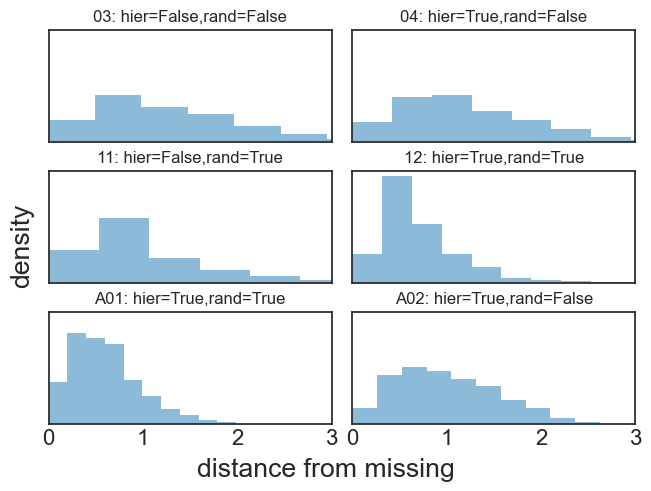

In [51]:
groups = emb_all_distmiss[emb_all_distmiss['dset_naics_holdout'] == 0] \
    .groupby('model')
ncol = 2
nrow = int(np.ceil(len(groups) / ncol))
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True,
                      layout='constrained')
i = 0
for n, g in groups:
    r = int(np.floor(i / ncol))
    c = i % ncol
    g[['dset_naics_holdout', 'dist_miss']] \
        .reset_index() \
        .pivot(index='index', columns='dset_naics_holdout',
           values='dist_miss') \
        .plot(kind='hist', bins=10, density=True, alpha=0.5,
             ax=ax[r, c])
    i+=1
    ax[r,c].get_legend().remove()
    ax[r,c].set_ylabel(None)
    ax[r,c].get_yaxis().set_visible(False)
    this_model_info = model_info_frame[model_info_frame['model'] == n].iloc[0,:]
    this_title = f'{n}: hier={this_model_info["model_hier"]},' + \
        f'rand={this_model_info["model_rand"]}'
    ax[r,c].set_title(this_title, fontsize=12)
#ax[0, 0].legend(title=None, labels=['test', 'holdout'], fontsize=12)
ax[0,0].set_xlim([0,3])
fig.supxlabel('distance from missing')
fig.supylabel('density')
fig.savefig(Path(setup.temp_path).joinpath('A11_PLOT_missing_distances.png'))

## Distances Box Plot
For both distance from center and missing, box plots to compare hier, random

In [52]:
dist_1 = emb_all[(emb_all['dset_naics_holdout'] == 1) &
                emb_all['model'].isin(['03', '11', 'A01', 'A02'])] \
    [['NAICS_orig', 'dist', 'model']] \
    .merge(model_info_frame[['model', 'model_hier', 'model_rand']], on='model')

In [53]:
dist_2 = emb_all_distmiss[(emb_all_distmiss['dset_naics_holdout'] == 0) &
                emb_all_distmiss['model'].isin(['03', '11', 'A01', 'A02'])] \
    .rename(columns={'dist':'dist_old', 'dist_miss':'dist'}) \
    [['NAICS_orig', 'dist', 'model']] \
    .merge(model_info_frame[['model', 'model_hier', 'model_rand']], on='model')

In [54]:
dist_1_median = dist_1.groupby(['model_hier', 'model_rand']) \
    ['dist'] \
    .agg('median') \
    .reset_index()
dist_1_median

,model_hier,model_rand,dist
0,False,False,1.031457
1,False,True,0.526339
2,True,False,0.862188
3,True,True,0.431421


In [55]:
dist_2_median = dist_2.groupby(['model_hier', 'model_rand']) \
    ['dist'] \
    .agg('median') \
    .reset_index()
dist_2_median

,model_hier,model_rand,dist
0,False,False,1.128820
1,False,True,0.822227
2,True,False,0.930666
3,True,True,0.541235


/var/folders/h9/4b0yxscx221gvjqy2cqp_kyh0000gn/T/ipykernel_24453/1983401110.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=['NAICS only', 'NAICS+hier'])


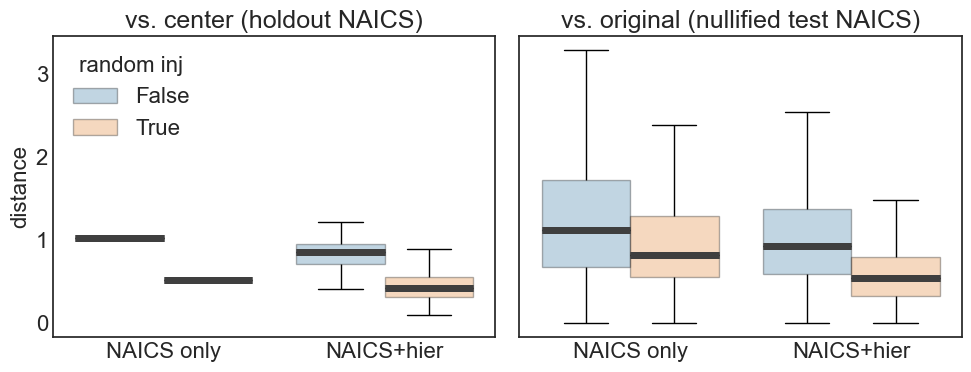

In [56]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True,
                      figsize=(10,4))
sns.boxplot(x='model_hier',y='dist',data=dist_1,hue='model_rand',
                linewidth=1, linecolor='black', boxprops=dict(alpha=.3),
            showfliers=False,
           ax=ax[0])
sns.boxplot(x='model_hier',y='dist',data=dist_1_median,hue='model_rand',
                linewidth=5, legend=None, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel('distance')
ax[0].set_title('vs. center (holdout NAICS)')
sns.boxplot(x='model_hier',y='dist',data=dist_2,hue='model_rand',
                linewidth=1, linecolor='black', boxprops=dict(alpha=.3), ax=ax[1],
            showfliers=False, legend=None)
#ax[1].legend(title=None, labels=['no rand', 'random inj'])
sns.boxplot(x='model_hier',y='dist',data=dist_2_median,hue='model_rand',
                linewidth=5, ax=ax[1], legend=None)
ax[1].set_xlabel(None)
ax[1].set_xticklabels(labels=['NAICS only', 'NAICS+hier'])
ax[1].set_title('vs. original (nullified test NAICS)')
fig.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels, title="random inj")
sns.move_legend(ax[0], "upper left")
fig.savefig(Path(setup.temp_path).joinpath('A11_PLOT_distances_boxplot.png'),
           bbox_inches='tight')

## Distances vs. NAICS level
Look at distances from center and to actual when multiple levels of the hierarchy are nullified.  A01, A02 only.

#### Distances to center

In [57]:
# Project missing cases onto the actual NAICS

In [58]:
miss_groups= emb_all_miss['miss_group'].drop_duplicates().to_list()

In [59]:
dist_frame = pd.DataFrame()
for mg in miss_groups:
    n= naics_features[mg+1:]
    print(n)
    this_miss_df = emb_all_miss[emb_all_miss['miss_group'] == mg]
    this_merge_1 = this_miss_df \
        .merge(emb_all[n+ ['model', 'dset_naics_holdout']], on=n+ ['model']) 
    this_merge_2 = this_merge_1.drop(columns=emb_features) \
        .merge(center_points, on='model')
    this_merge_1['dist'] = np.sqrt((this_merge_2[emb_features] - this_merge_1[emb_features]) \
        .pow(2).sum(axis=1))
    this_merge_1['num_naics'] = len(n)
    dist_frame = pd.concat([dist_frame, this_merge_1])

['NAICS_4_orig', 'NAICS_3_orig', 'NAICS_sector_orig']
['NAICS_3_orig', 'NAICS_sector_orig']
['NAICS_sector_orig']
[]


In [60]:
# Append the original distances
dist_frame = pd.concat([emb_all[emb_all['model'].isin(['A01', 'A02'])],
                        dist_frame])
dist_frame['num_naics'] = dist_frame['num_naics'].fillna(len(naics_features))
                                

In [61]:
dist_frame['num_naics'].value_counts()

num_naics
4.0    2622
2.0    2622
1.0    2622
0.0    2622
3.0    2618
Name: count, dtype: int64

In [62]:
dist_frame = dist_frame.merge(model_info_frame[['model', 'model_rand']],
                              on='model')

<Axes: xlabel='num_naics', ylabel='dist'>

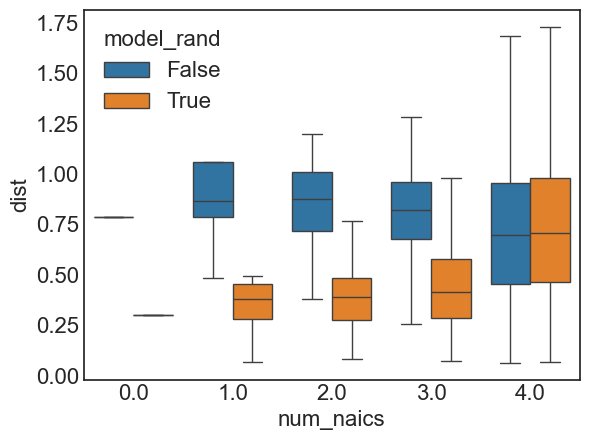

In [63]:
sns.boxplot(x='num_naics',y='dist',
            data=dist_frame[dist_frame['dset_naics_holdout'] == 0],
            hue='model_rand',
           showfliers=False)

##### Distances to actuall

In [64]:
dist_a_frame = pd.DataFrame()
for mg in miss_groups:
    n= naics_features[mg+1:]
    print(n)
    this_miss_df = emb_all_miss[emb_all_miss['miss_group'] == mg]
    this_merge_1 = this_miss_df.drop(columns=emb_features)  \
        .merge(emb_all[n+ ['model', 'dset_naics_holdout'] + emb_features], on=n+ ['model']) 
    this_merge_2 = this_miss_df \
        .merge(emb_all[n+ ['model', 'dset_naics_holdout']], on=n+ ['model']) 
    this_merge_1['dist'] = np.sqrt((this_merge_2[emb_features] - this_merge_1[emb_features]) \
        .pow(2).sum(axis=1))
    this_merge_1['num_naics'] = len(n)
    dist_a_frame = pd.concat([dist_a_frame, this_merge_1]) \
        .reset_index(drop=True)

['NAICS_4_orig', 'NAICS_3_orig', 'NAICS_sector_orig']
['NAICS_3_orig', 'NAICS_sector_orig']
['NAICS_sector_orig']
[]


In [65]:
# Add in the full-hierarchy values
dist_a_frame = pd.concat([emb_all_distmiss[emb_all_distmiss['model'].isin(['A01', 'A02'])] \
                              .rename(columns={'dist':'dist_old',
                                               'dist_miss':'dist'}),
                        dist_a_frame])
dist_a_frame['num_naics'] = dist_a_frame['num_naics'].fillna(len(naics_features))
dist_a_frame = dist_a_frame.merge(model_info_frame[['model', 'model_rand']],on='model')

<Axes: xlabel='num_naics', ylabel='dist'>

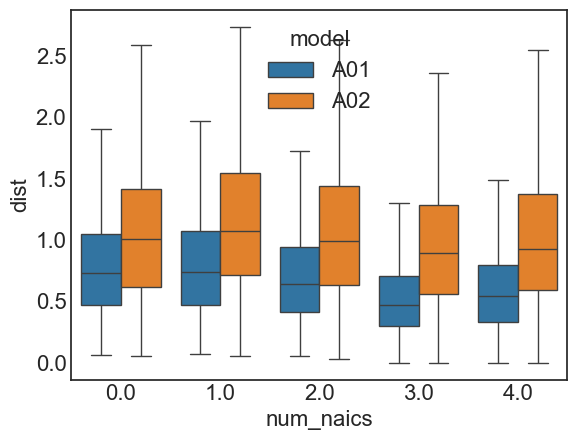

In [66]:
sns.boxplot(x='num_naics',y='dist',
            data=dist_a_frame[dist_a_frame['dset_naics_holdout'] == 0],
            hue='model',
           showfliers=False)

##### Combined boxplot

/var/folders/h9/4b0yxscx221gvjqy2cqp_kyh0000gn/T/ipykernel_24453/1847587495.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=['none\n(all null)', 'sector\nonly\n','sub\nsector\n(3+dig)',


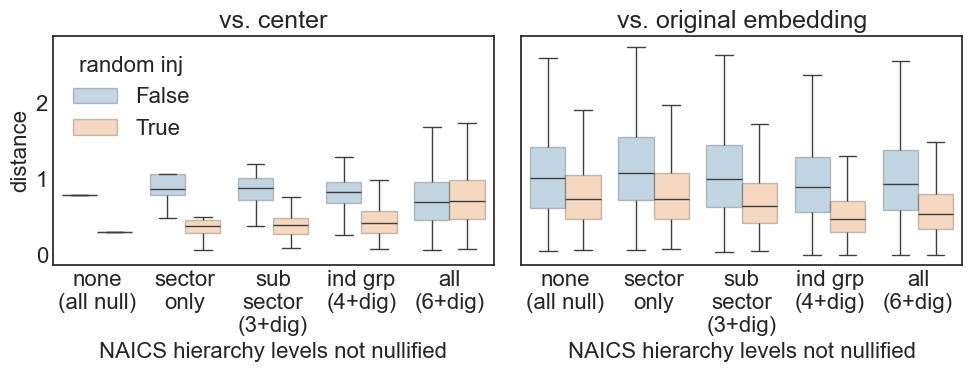

In [67]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True,
                      figsize=(10,4))

sns.boxplot(x='num_naics',y='dist',
            data=dist_frame[dist_frame['dset_naics_holdout'] == 0],
            hue='model_rand',
           showfliers=False, boxprops=dict(alpha=.3),
           ax=ax[0])
sns.boxplot(x='num_naics',y='dist',
            data=dist_a_frame[dist_a_frame['dset_naics_holdout'] == 0],
            hue='model_rand', boxprops=dict(alpha=.3),
            ax=ax[1], legend=None,
           showfliers=False)

xlab = 'NAICS hierarchy levels not nullified'
ax[0].set_xlabel(xlab)
ax[0].set_ylabel('distance')
ax[0].set_title('vs. center')
ax[1].set_title('vs. original embedding')
ax[1].set_xlabel(xlab)

ax[1].set_xticklabels(labels=['none\n(all null)', 'sector\nonly\n','sub\nsector\n(3+dig)', 
                              'ind grp\n(4+dig)', 'all\n(6+dig)'])
#ax[1].set_title(dist_2['title'].iloc[1])
fig.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels, title="random inj")
sns.move_legend(ax[0], "upper left")
#fig.supxlabel(xlab y=-0.05)
fig.savefig(Path(setup.temp_path).joinpath('A11_PLOT_distances_boxplot_naics_hier.png'),
           bbox_inches='tight')

## TSNE Plot- Level Nullification

In [68]:
# Get 10% of non-holdout NAICS for plotting

In [69]:
emb_nh = emb_all[(emb_all['dset_naics_holdout'] == 0) &
                (emb_all['model'].isin(['A01', 'A02']))].copy() \
    .reset_index(drop=True)
emb_nh.index.name = 'index'
emb_nh.reset_index(inplace=True)

In [70]:
keep_emb, null_emb = train_test_split(emb_nh.index, train_size=0.9, random_state=23221)

In [71]:
emb_nh['nullified_flag'] = np.where(emb_nh.index.isin(null_emb), 1, 0)

In [72]:
emb_nh['nullified_flag'].value_counts(normalize=True)

nullified_flag
0    0.9
1    0.1
Name: proportion, dtype: float64

In [73]:
keep_emb_df = emb_nh[emb_nh['nullified_flag'] == 0]
null_emb_df = emb_nh[emb_nh['nullified_flag'] == 1]

In [74]:
emb_miss_sel = pd.DataFrame()
for mg in miss_groups:
    n= naics_features[mg+1:]
    print(n)
    # Get values for nullified ones
    this_miss_df = null_emb_df[n+ ['model', 'nullified_flag', 'index']] \
        .merge(emb_all_miss[emb_all_miss['miss_group'] == mg],
               on=n+ ['model']) 
    # Add in the kept ones, flagging the nullified
    this_miss_comb = pd.concat([keep_emb_df, this_miss_df],
                              keys=[0,1])
    this_miss_comb['num_naics'] = len(n)
    emb_miss_sel = pd.concat([emb_miss_sel, this_miss_comb])

['NAICS_4_orig', 'NAICS_3_orig', 'NAICS_sector_orig']
['NAICS_3_orig', 'NAICS_sector_orig']
['NAICS_sector_orig']
[]


In [75]:
emb_miss_sel.groupby('model')['nullified_flag'].value_counts()

model  nullified_flag
A01    0                 4264
       1                  456
A02    0                 4232
       1                  488
Name: count, dtype: int64

In [76]:
# Add in the original values
# Add in the full-hierarchy values
emb_miss_sel = pd.concat([emb_nh[[c for c in emb_nh.columns if c in emb_miss_sel.columns]],
                        emb_miss_sel])
emb_miss_sel['num_naics'] = emb_miss_sel['num_naics'].fillna(len(naics_features))
emb_miss_sel = emb_miss_sel.merge(model_info_frame[['model', 'model_rand']],on='model')

In [77]:
emb_miss_sel.groupby('model')['nullified_flag'].value_counts()

model  nullified_flag
A01    0                 5330
       1                  570
A02    0                 5290
       1                  610
Name: count, dtype: int64

##### Calculate new TSNE values with nullified cases

In [78]:
importlib.reload(sbnn_embed)

<module 'sba_nn.sba_nn.sbnn_embed' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_embed.py'>

In [79]:
groups = emb_miss_sel.set_index('index', append=True) \
    .groupby(['model', 'num_naics'])
tsne_raw_null = pd.concat([sbnn_embed.tsne_transform(g[emb_features]) \
                               for n, g in groups],
                     keys=groups.groups.keys()) 

In [80]:
tsne_raw_null.index.names = ['model', 'num_naics'] + tsne_raw_null.index.names[2:]
tsne_raw_null.columns = ['tsne_' + str(c) for c in tsne_raw_null.columns]

In [81]:
tsne_raw_null

tsne_0     tsne_1
model num_naics      index                      
A01   0.0       4720 0     -49.357685   2.736613
                4721 1     -25.513548  12.756116
                4722 2     -22.567499   0.926484
                4723 3     -46.026833  -4.893946
                4724 4     -44.302467   3.366055
...                               ...        ...
A02   4.0       7075 2355   12.515038 -12.127160
                7076 2356  -26.241539   4.491974
                7077 2357   45.349747  -4.102553
                7078 2358    9.589085  19.419083
                7079 2359   30.594753  10.825856

[11800 rows x 2 columns]

In [82]:
# Add in the information about nullification
tsne_raw_null_df = tsne_raw_null.reset_index(['model', 'num_naics', 'index']) \
    .merge(emb_nh[['model', 'index', 'nullified_flag', 'NAICS_orig']],
           on=['model', 'index']) \
    .merge(naics_info[['NAICS_orig','NAICS_sector_orig', 'target_thresh', 'count',
                      'dset_naics_holdout']], 
           how='left', on ='NAICS_orig') 

In [83]:
tsne_raw_null_df['nullified_flag'].value_counts(dropna=False)

nullified_flag
0    10620
1     1180
Name: count, dtype: int64

#### Randomized model A01

In [84]:
tsne_1 = tsne_raw_null_df[tsne_raw_null_df['model'] == 'A01']

In [85]:
groups = tsne_1.groupby('num_naics')

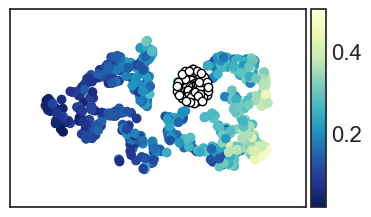

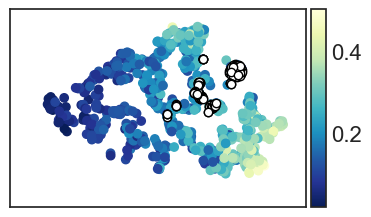

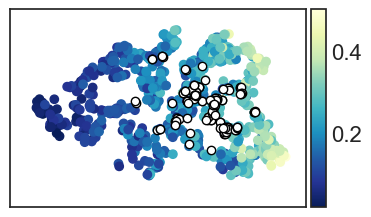

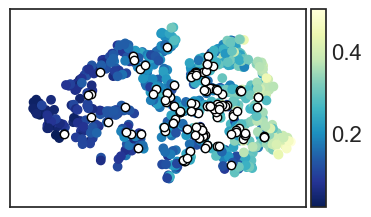

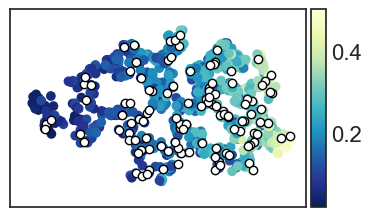

In [86]:
for n, g in groups:
    sbnn_embed.emb_color_plot(g, 'target_thresh', 'nullified_flag',
                                holdout_fill = 'white',
                                cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                                title_str='', figsize=(4,4),
                                xlabel='', ylabel='', show_axes=False,
                                xlim=[-65,55], ylim=[-40, 40],
                              outfile_folder=Path(setup.temp_path),
                         outfile_prefix = f'A11_PLOT_naics_setmiss_A01_{int(n):02d}.png')

#### Raw model A02

In [87]:
tsne_2 = tsne_raw_null_df[tsne_raw_null_df['model'] == 'A02']

In [88]:
groups = tsne_2.groupby('num_naics')

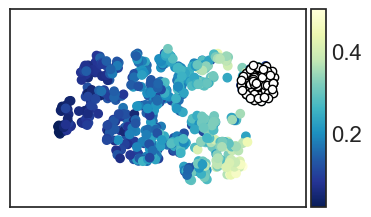

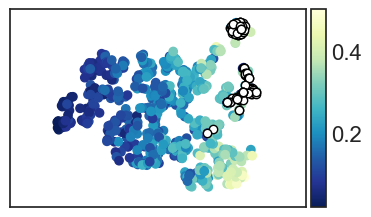

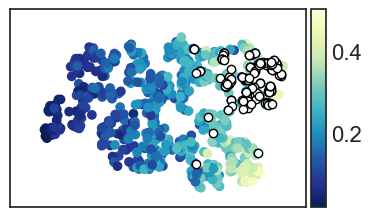

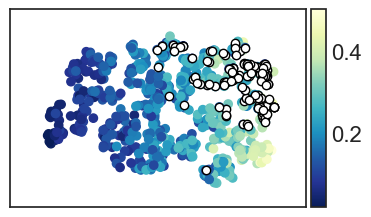

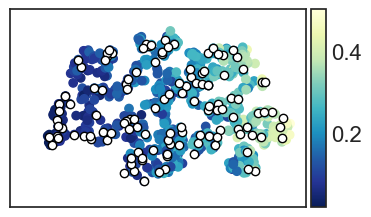

In [89]:
for n, g in groups:
    sbnn_embed.emb_color_plot(g, 'target_thresh', 'nullified_flag',
                                holdout_fill = 'white',
                                cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                                title_str='', figsize=(4,4),
                                xlabel='', ylabel='', show_axes=False,
                                xlim=[-65,55], ylim=[-40, 40],
                              outfile_folder=Path(setup.temp_path),
                              outfile_prefix = f'A11_PLOT_naics_setmiss_A02_{int(n):02d}.png')

In [90]:
tsne_raw_null_df.to_parquet(Path(setup.temp_path).joinpath('A11_DATA_null_tsne.parquet'))